In [1]:
# 載入套件
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as datetime
from fbprophet import Prophet
from sklearn import metrics

In [2]:
# 設定資料視覺化開始日期
start = datetime.datetime(2019,1,1)
df_2330 = pdr.DataReader('2330.TW', 'yahoo', start=start)
df_2330.head() #印出開始日期之前五筆資料

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,226.5,219.0,226.5,219.5,32900482,219.5
2019-01-03,218.0,214.0,214.0,215.5,34087620,215.5
2019-01-04,211.5,206.5,211.5,208.0,65943521,208.0
2019-01-07,214.0,211.0,212.0,213.0,35442176,213.0
2019-01-08,212.5,210.0,212.0,211.0,22694481,211.0


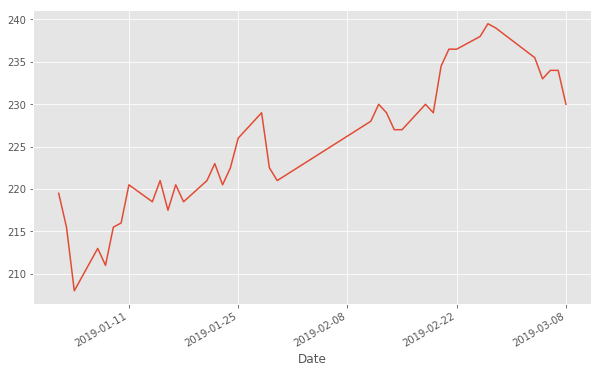

In [3]:
#印出開始日期至今天的走勢
plt.style.use('ggplot')
df_2330['Adj Close'].plot(figsize=(10, 6));

In [4]:
#定義資料
new_df_2330 = pd.DataFrame(df_2330['Adj Close']).reset_index().rename(columns={'Date':'ds', 'Adj Close':'y'})
new_df_2330.head()

,ds,y
0,2019-01-02,219.5
1,2019-01-03,215.5
2,2019-01-04,208.0
3,2019-01-07,213.0
4,2019-01-08,211.0


In [5]:
new_df_2330['y'] = np.log(new_df_2330['y'])
# 定義模型
model = Prophet()

# 訓練模型
model.fit(new_df_2330)

# 建構預測集
future = model.make_future_dataframe(periods=7) #forecasting for 80 days from now.

# 進行預測
forecast = model.predict(future)

forecast.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/deanchu/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yhat
0,2019-01-02,5.369179,5.369179,5.369179,5.359401,5.386033,0.003113,0.003113,0.003113,0.0,0.0,0.0,0.003113,0.003113,0.003113,5.372292
1,2019-01-03,5.365794,5.365794,5.365794,5.355120,5.382742,0.003135,0.003135,0.003135,0.0,0.0,0.0,0.003135,0.003135,0.003135,5.368929
2,2019-01-04,5.362409,5.362409,5.362409,5.346888,5.374584,-0.002135,-0.002135,-0.002135,0.0,0.0,0.0,-0.002135,-0.002135,-0.002135,5.360274
3,2019-01-07,5.364210,5.364210,5.364210,5.354711,5.382894,0.005128,0.005128,0.005128,0.0,0.0,0.0,0.005128,0.005128,0.005128,5.369338
4,2019-01-08,5.364810,5.364810,5.364810,5.352055,5.380892,0.001467,0.001467,0.001467,0.0,0.0,0.0,0.001467,0.001467,0.001467,5.366277


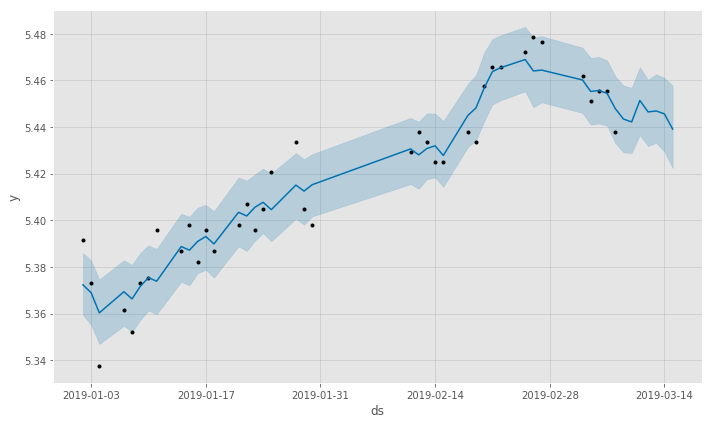

In [6]:
#印出預測結果
figure=model.plot(forecast)

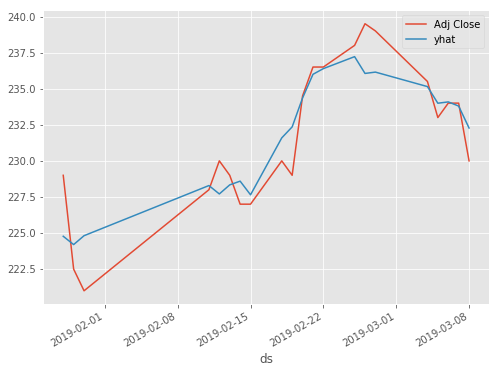

In [7]:
#將預測值與實際值進行疊合
df_2330_close = pd.DataFrame(df_2330['Adj Close'])
two_years = forecast.set_index('ds').join(df_2330_close)
two_years = two_years[['Adj Close', 'yhat', 'yhat_upper', 'yhat_lower' ]].dropna().tail(21)
two_years['yhat']=np.exp(two_years.yhat)
two_years['yhat_upper']=np.exp(two_years.yhat_upper)
two_years['yhat_lower']=np.exp(two_years.yhat_lower)
two_years[['Adj Close', 'yhat']].plot(figsize=(8, 6));

In [8]:
two_years_AE = (two_years.yhat - two_years['Adj Close'])
two_years_AE.describe()

count    21.000000
mean      0.037543
std       2.061680
min      -4.223459
25%      -0.663067
50%      -0.108805
75%       1.592758
max       3.816579
dtype: float64

In [9]:
print ("MSE:",metrics.mean_squared_error(two_years.yhat, two_years['Adj Close']))

MSE: 4.049527276702419


In [10]:
print ("MAE:",metrics.mean_absolute_error(two_years.yhat, two_years['Adj Close']))

MAE: 1.5197988805835534


Text(0.5,0,'Date')

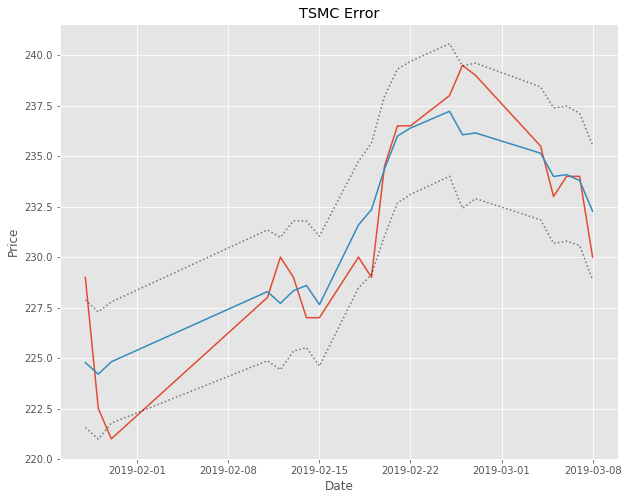

In [11]:
#疊加實際值與預測值，灰色為預測上下限
fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.plot(two_years['Adj Close'])
ax1.plot(two_years.yhat)
ax1.plot(two_years.yhat_upper, color='black',  linestyle=':', alpha=0.5)
ax1.plot(two_years.yhat_lower, color='black',  linestyle=':', alpha=0.5)

ax1.set_title('TSMC Error')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

In [12]:
import matplotlib
matplotlib.matplotlib_fname()

'/Users/deanchu/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc'